# DE calibration analysis

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import shutil

from copy import deepcopy
import argparse

sys.path.append(os.path.abspath('../'))
from utils import _convert_oak_path

from MultiStatePerturbSeqDataset import *
from DE_analysis_utils import *

import yaml

# Load color palettes from yaml file
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 600

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


sys.path.append(os.path.abspath('../'))
from utils import _convert_oak_path
from merge_DE_results import parse_DE_results_2_adata


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [ ]:
# Load configuration from YAML file
with open('DE_config_full.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']

# Load pseudobulk data
pbulk_adata = anndata.experimental.read_lazy(f'{datadir}/{experiment_name}/{experiment_name}_merged.DE_pseudobulk.h5ad')
pbulk_adata = pbulk_adata[(pbulk_adata.obs['keep_for_DE']) & (pbulk_adata.obs['perturbed_gene_name'] == 'NTC')].copy()
pbulk_adata = pbulk_adata.to_memory()

In [3]:
# Load configuration from YAML file
with open('DE_config_full.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']
run_name = config.get('run_name', 'default')
datadir = f'{datadir}/{experiment_name}'
de_results_dir = f'{datadir}/DE_results_{run_name}/'

In [3]:
# Keep genes to test
de_test_genes = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad').var_names.copy()
pbulk_adata = pbulk_adata[:, de_test_genes].copy()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/oak/users/emma/data/GWT//DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [189]:
def _run_DE_calibration(pbulk_adata, cond, run_de_params, design_formula, min_counts_per_gene = 10):    
    pdata = pbulk_adata[pbulk_adata.obs['culture_condition'] == cond].copy()
    # Run DE analysis
    ms_perturb_data = MultistatePerturbSeqDataset(
        pdata,
        sample_cols = ['cell_sample_id'],
        perturbation_type = 'CRISPRi',
        target_col = 'perturbed_gene_id',
        sgrna_col = 'guide_id',
        state_col = 'culture_condition',
        control_level = 'NTC'
        )
    model, results = ms_perturb_data.run_target_DE(
        design_formula = design_formula,
        test_state = [cond], test_targets=['ENSG0000X'],
        min_counts_per_gene = min_counts_per_gene,
        return_model = True,
        n_cpus=5
        )
    results['design'] = design_formula
    results['culture_condition'] = cond
    return(results)
    

# Make 3 different splits using 5 different seeds
split_results = []
split_seeds = [42, 123, 2024, 5467, 3232]

# Keep guides with reasonable n of cells
n_cells_ntc_guide = pbulk_adata.obs.groupby('guide_id')['n_cells'].sum()
lower_05, upper_95 = n_cells_ntc_guide.quantile([0.05, 0.95])
all_ntc_guides = n_cells_ntc_guide[(n_cells_ntc_guide >= lower_05) & (n_cells_ntc_guide <= upper_95)].index.tolist()
n_sample = 2 # Same number as targeting guides per gene

for split_idx, seed in enumerate(split_seeds):
    np.random.seed(seed)
    fake_target_ntc_guides = np.random.choice(all_ntc_guides, size=n_sample, replace=False)
    # Add a split-specific column for identifier and label
    pbulk_adata.obs[f'perturbed_gene_id_split{split_idx+1}'] = np.where(
        pbulk_adata.obs['guide_id'].isin(fake_target_ntc_guides), 'ENSG0000X', 'NTC')
    pbulk_adata.obs[f'perturbed_gene_name_split{split_idx+1}'] = np.where(
        pbulk_adata.obs['guide_id'].isin(fake_target_ntc_guides), 'TARGET', 'NTC')
   
    split_results.append(pbulk_adata.obs[f'perturbed_gene_name_split{split_idx+1}'].value_counts())

In [190]:
for split_idx, seed in enumerate(split_seeds):
    print(pbulk_adata.obs.groupby(f'perturbed_gene_id_split{split_idx+1}')['n_cells'].mean())

perturbed_gene_id_split1
ENSG0000X    57.000000
NTC          91.099105
Name: n_cells, dtype: float64
perturbed_gene_id_split2
ENSG0000X    59.888889
NTC          91.084103
Name: n_cells, dtype: float64
perturbed_gene_id_split3
ENSG0000X    55.913043
NTC          91.108171
Name: n_cells, dtype: float64
perturbed_gene_id_split4
ENSG0000X    57.095238
NTC          91.098911
Name: n_cells, dtype: float64
perturbed_gene_id_split5
ENSG0000X    45.000000
NTC          91.119129
Name: n_cells, dtype: float64


In [ ]:
# Display value counts for each split
all_res_df = pd.DataFrame()
for idx, res in enumerate(split_results):
    for c in ['Rest', 'Stim8hr', 'Stim48hr']:
        pbulk_adata.obs['perturbed_gene_id'] = pbulk_adata.obs[f'perturbed_gene_id_split{idx+1}'].copy()
        pbulk_adata.obs['perturbed_gene_name'] = pbulk_adata.obs[f'perturbed_gene_name_split{idx+1}'].copy()
        res_df = _run_DE_calibration(
            pbulk_adata, cond=c,
            run_de_params = config.get('run_DE_params', {}),
            design_formula = config.get('run_DE_params', {}).get('design_formula', '~ log10_n_cells + target'),
            )
        res_df['seed'] = split_seeds[idx]
        all_res_df = pd.concat([all_res_df, res_df])

In [193]:
all_res_df.to_csv(f'{de_results_dir}/DE_calibration_results.csv')

### Plot results

In [ ]:
all_res_df = pd.read_csv(f'{de_results_dir}/DE_calibration_results.csv')
all_res_df['seed'].unique()

array([  42,  123, 2024, 5467, 3232])

In [5]:
(all_res_df['adj_p_value'] < 0.1).value_counts()

adj_p_value
False    196413
True         17
Name: count, dtype: int64

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pvalue_qq(pvalues, title="P-value QQ Plot", ax=None):
    """
    Create a QQ plot to assess p-value calibration using -log10 scale.

    Parameters:
    -----------
    pvalues : array-like
        Vector of p-values to assess
    title : str
        Title for the plot
    ax : matplotlib.axes.Axes or None
        Axes to plot on. If None, creates a new figure and axes.
    """
    # Remove NaN values and sort
    pvalues = np.array(pvalues)
    pvalues = pvalues[~np.isnan(pvalues)]
    pvalues_sorted = np.sort(pvalues)

    # Calculate expected p-values under uniform distribution
    n = len(pvalues_sorted)
    expected = np.arange(1, n + 1) / (n + 1)

    # Transform to -log10 scale
    observed_log = -np.log10(pvalues_sorted)
    expected_log = -np.log10(expected)

    # Prepare axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    # else: use provided ax

    # Create the plot
    ax.scatter(expected_log, observed_log, alpha=0.6, s=20)

    # Add diagonal line (y=x) representing perfect calibration
    max_expected = expected_log.max()
    ax.plot([0, max_expected], [0, max_expected], 'r--', linewidth=2, label='Perfect calibration')
    ax.set_xlim(0, max_expected)
    # Add confidence bands (optional)
    from scipy.stats import beta
    lower = beta.ppf(0.025, np.arange(1, n + 1), n - np.arange(1, n + 1) + 1)
    upper = beta.ppf(0.975, np.arange(1, n + 1), n - np.arange(1, n + 1) + 1)
    lower_log = -np.log10(lower)
    upper_log = -np.log10(upper)
    ax.fill_between(expected_log, lower_log, upper_log, alpha=0.2, color='gray',
                    label='95% confidence band')

    ax.set_xlabel('Expected -log10(p-value)', fontsize=12)
    ax.set_ylabel('Observed -log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    if ax is None:
        return plt
    else:
        return ax


# Plot Q-Q plot of p-values in one figure, separate axes for each condition and seed
split_seeds = all_res_df['seed'].unique()
n_seeds = len(split_results)
n_conds = 3  # 'Rest', 'Stim8hr', 'Stim48hr'
fig, axes = plt.subplots(n_seeds, n_conds, figsize=(8*n_conds, 8*n_seeds), squeeze=False)

for idx, res in enumerate(split_results):
    for jdx, c in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
        results = all_res_df[(all_res_df['culture_condition'] == c) & (all_res_df['seed'] == split_seeds[idx])]
        qq_title = f"Q-Q plot: {c}, seed={split_seeds[idx]}"
        plot_pvalue_qq(results.p_value.dropna(), title=qq_title, ax=axes[idx, jdx])

plt.tight_layout()
plt.show()

In [14]:
adata_de_targeting = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [15]:
np.random.seed(42)
all_targets = adata_de_targeting.obs['target_contrast_gene_name'].unique()
# Sample 100 targets at random
sampled_targets = np.random.choice(all_targets, size=30, replace=False)
de_results_df = get_DE_results_long(adata_de_targeting, targets=sampled_targets, signif_estimate='adj_p_value', effect_estimates=['p_value'])

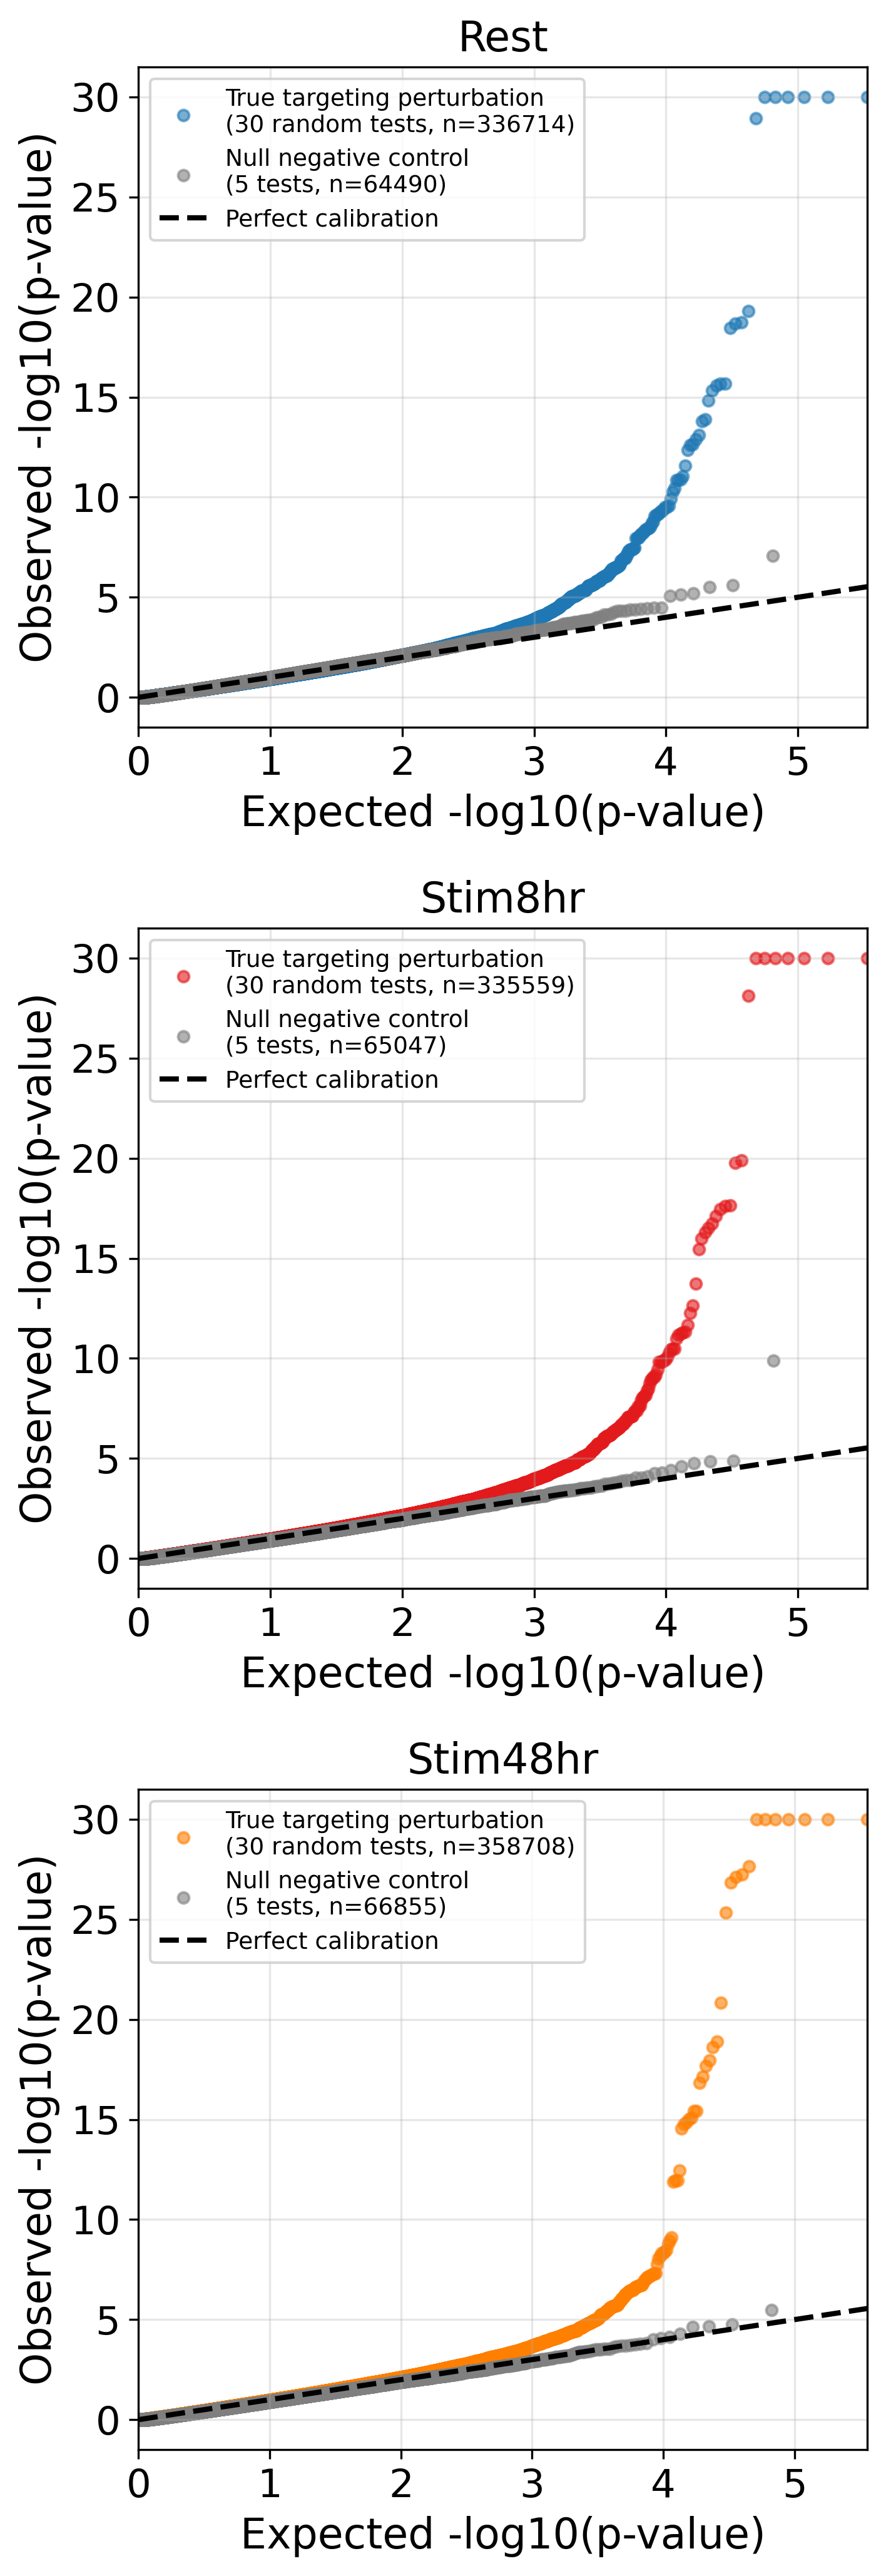

In [17]:
from scipy.stats import beta

import matplotlib.pyplot as plt
import numpy as np

def plot_pvalue_qq_df(df, ax=None, title='Q-Q plot of p-values by test', color_dict=None):
    """
    Plot Q-Q plot for p-values grouped by 'test' column. Each curve is a test.
    Args:
        df: DataFrame with columns ['p_value', 'test'].
        ax: matplotlib axis object (optional).
        title: Plot title.
        color_dict: Optional dict to map 'test' name to color.
    Returns:
        matplotlib axis object or plt
    """
    tests = df['test'].unique()
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    max_x = 0
    for idx, test in enumerate(tests):
        test_pvalues = np.array(df.loc[df['test'] == test, 'p_value'])
        test_pvalues = test_pvalues[~np.isnan(test_pvalues)]
        test_pvalues_sorted = np.sort(test_pvalues)
        n = len(test_pvalues_sorted)
        if n == 0:
            continue

        expected = np.arange(1, n + 1) / (n + 1)
        observed_log = -np.log10(test_pvalues_sorted)
        observed_log = np.where(observed_log > 30, 30, observed_log)
        expected_log = -np.log10(expected)
        # Track the all-dataset max for diagonal
        max_x = max(max_x, expected_log.max())

        color = None
        if color_dict is not None and test in color_dict:
            color = color_dict[test]

        ax.scatter(expected_log, observed_log,
                   alpha=0.6, s=18,
                   label=str(test) if len(tests)<16 else None,
                   color=color,
                   rasterized=True
                   )

    # Add diagonal line (y = x)
    ax.plot([0, max_x], [0, max_x], '--', linewidth=2, label='Perfect calibration', color='black')
    ax.set_xlim(0, max_x)
    ax.set_xlabel('Expected -log10(p-value)', fontsize=16)
    ax.set_ylabel('Observed -log10(p-value)', fontsize=16)
    ax.set_title(title, fontsize=16)
    if len(tests) < 16:
        ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return ax

# Create a color mapping for the two classes for each condition
# e.g. { "True targeting perturbation ...": palettes['culture_condition'][c],  "Negative control ...": 'gray' }
colors = {}
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    colors[c] = {
        f'True targeting perturbation\n(30 random tests, n={{n}})': palettes['culture_condition'][c],
        f'Null negative control\n(5 tests, n={{n}})': 'gray'
    }

fig, axes = plt.subplots(3, 1, figsize=(5, 14), sharey=True)
for i, c in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    res_df = all_res_df[all_res_df['culture_condition'] == c].dropna().copy()
    res_df['test'] = f'Null negative control\n(5 tests, n={res_df.shape[0]})'
    true_res_df = de_results_df[de_results_df['culture_condition'] == c].dropna().copy()
    true_res_df['test'] = f'True targeting perturbation\n(30 random tests, n={true_res_df.shape[0]})'
    plot_df = pd.concat([true_res_df, res_df])[['test', 'p_value']].copy()
    # Make color mapping based on actual n
    cond_colors = {
        f'True targeting perturbation\n(30 random tests, n={true_res_df.shape[0]})': palettes['culture_condition'][c],
        f'Null negative control\n(5 tests, n={res_df.shape[0]})': 'gray'
    }
    plot_pvalue_qq_df(plot_df, ax=axes[i], title=c, color_dict=cond_colors)
plt.tight_layout()
plt.savefig('./results/calibration_qqplots.pdf')
plt.savefig('./results/calibration_qqplots.png')